In [16]:
pip install python-louvain


     ---------------------------------------- 0.0/204.6 kB ? eta -:--:--
     ------------------------------------ - 194.6/204.6 kB 5.9 MB/s eta 0:00:01
     -------------------------------------- 204.6/204.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9403 sha256=5c7a375dc16594d86a94a17e5b15154c0621c2e02d7d26a18e60464a2be11910
  Stored in directory: c:\users\afreitas\appdata\local\pip\cache\wheels\11\c1\e7\f62a211c636275e2da798bf0c307a3ae79aeddaf2524a03ce4
Successfully built python-louvain


In [1]:
import json
import numpy as np
from scipy.special import rel_entr
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN

In [2]:
# Function to calculate KL divergence using rel_entr
def kl_divergence(p, q):
    return np.sum(rel_entr(p, q))

def symmetrized_kl_divergence(p, q):
    return 0.5 * (kl_divergence(p, q) + kl_divergence(q, p))

# Function to calculate Jensen-Shannon divergence
def jensen_shannon_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * np.sum(rel_entr(p, m)) + 0.5 * np.sum(rel_entr(q, m))

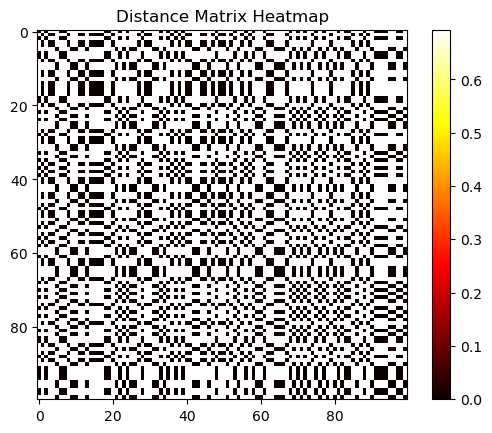

[[0.00000000e+00 6.93147181e-01 7.51528042e-07 ... 0.00000000e+00
  0.00000000e+00 6.93147181e-01]
 [6.93147181e-01 0.00000000e+00 6.93147181e-01 ... 6.93147181e-01
  6.93147181e-01 6.93147181e-01]
 [7.51528042e-07 6.93147181e-01 0.00000000e+00 ... 7.51528042e-07
  7.51528042e-07 6.93147181e-01]
 ...
 [0.00000000e+00 6.93147181e-01 7.51528042e-07 ... 0.00000000e+00
  0.00000000e+00 6.93147181e-01]
 [0.00000000e+00 6.93147181e-01 7.51528042e-07 ... 0.00000000e+00
  0.00000000e+00 6.93147181e-01]
 [6.93147181e-01 6.93147181e-01 6.93147181e-01 ... 6.93147181e-01
  6.93147181e-01 0.00000000e+00]]


In [58]:
import matplotlib.pyplot as plt


def get_distributions_and_ids_from_json(filename):
    # Load JSON data
    with open(f'{filename}.json', 'r') as file:
        data = json.load(file)

    # Define epsilon
    epsilon = 1e-10

    # Extract and preprocess class distributions
    distributions = []
    ids = []

    for item in data:
        ids.append(item['id'])
        class_dist = item['class_distribution']
        sorted_class_counts = [class_dist[str(i)] if str(i) in class_dist else 0 for i in range(10)]
        class_distribution = [(count if count > 0 else epsilon) for count in sorted_class_counts]
        distributions.append(np.array(class_distribution))
    
    return distributions, ids

def calculate_pairwise_distance_matrix(distributions, ids):
    # Calculate the pairwise KL divergence distance matrix
    num_distributions = len(distributions)
    distance_matrix = np.zeros((num_distributions, num_distributions))
    
    for i in range(num_distributions):
        for j in range(i + 1, num_distributions):
            distance_matrix[i, j] = jensen_shannon_divergence(distributions[i], distributions[j])
            distance_matrix[j, i] = distance_matrix[i, j]
            
    return distance_matrix


filename = 'client_data_partition_by_label'

distributions, ids = get_distributions_and_ids_from_json(filename)

distance_matrix = calculate_pairwise_distance_matrix(distributions, ids)
        
# Visualize the distance matrix to help choose `eps`
plt.imshow(distance_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Distance Matrix Heatmap")
plt.show()


# print distance matrix
print(distance_matrix)

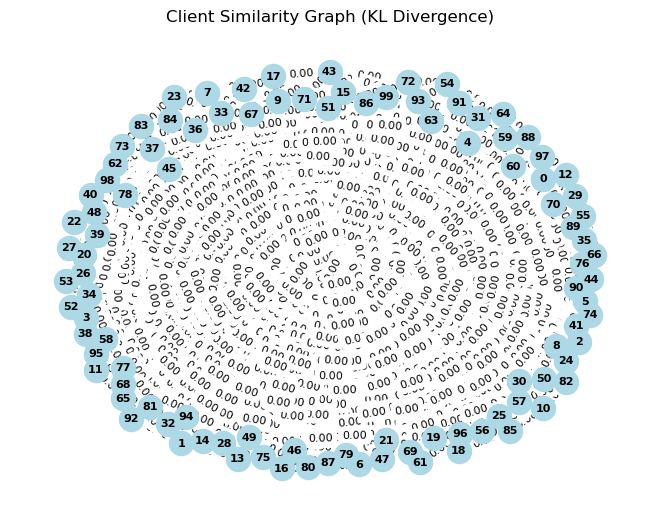

In [71]:
import networkx as nx

def create_graph_from_distances(ids, distance_matrix, threshold = 0):
    # Create a graph
    G = nx.Graph()

    # Add nodes with their corresponding IDs
    for node_id in ids:
        G.add_node(node_id)
    
    # Add edges with weights based on the distance matrix
    for i in range(num_distributions):
        for j in range(i + 1, num_distributions):
            if distance_matrix[i, j] > threshold:  # Add an edge only if there's a positive distance
                #similarity = 1 / (1 + distance_matrix[i, j])  # Convert dissimilarity to similarity
                G.add_edge(ids[i], ids[j], weight=similarity)
    return G


def draw_graph(G):
    # Draw the graph with better visibility
    pos = nx.spring_layout(G, k=0.5, scale=10)  # Increase the scale significantly
    weights = nx.get_edge_attributes(G, 'weight')

    # Draw nodes and edges
    nx.draw(G, pos, with_labels=True, node_size=300, node_color='lightblue', font_size=8, font_color='black', font_weight='bold')
    nx.draw_networkx_edges(G, pos, width=[w * 5 for w in weights.values()])  # Reduce edge width
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{w:.2f}" for u, v, w in G.edges(data='weight')}, font_size=8, label_pos=0.5)

    # Set the title and display the graph
    plt.title("Client Similarity Graph (KL Divergence)")
    plt.show()


G =  create_graph_from_distances(ids, distance_matrix)
draw_graph(G)


Applying Louvain Algorithm

In [72]:
import community as community_louvain  # Import Louvain algorithm

# Calculate the Minimum Spanning Tree (MST)
MST = nx.minimum_spanning_tree(G, weight='weight')

# Apply the Louvain algorithm to find communities
partition = community_louvain.best_partition(MST, weight='weight')

def print_communities(partition):
    # Print nodes in each community
    communities = {}
    for node, community_id in partition.items():
        if community_id not in communities:
            communities[community_id] = []
        communities[community_id].append(node)

    for community_id, nodes in communities.items():
        print(f"Community {community_id}: {nodes}")


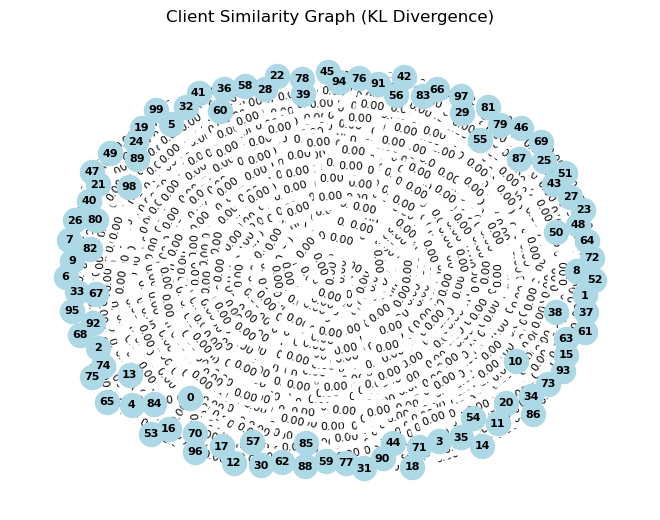

In [73]:
# Step 2: Calculate the cosine similarity matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim_matrix = cosine_similarity(distributions)

G_cosine = create_graph_from_distances(ids, cosine_sim_matrix)

draw_graph(G_cosine)

In [75]:
# Apply the Louvain algorithm to find communities
partition = community_louvain.best_partition(G_cosine, weight='weight')

print_communities(partition)

# Calculate modularity of the partition
modularity = community_louvain.modularity(partition, G_cosine, weight='weight')
print(f"Modularity: {modularity}")

Community 0: ['91', '7', '70', '25', '15', '53', '68', '90', '28', '48', '63', '14', '6', '47', '32', '24', '9', '8', '94', '95', '31', '64', '75', '46', '69', '42', '38', '13', '78', '5', '22', '61', '35', '74', '45', '87', '3', '97', '10', '92', '2', '99', '50', '40', '18', '27', '39', '30', '84', '19', '20', '56', '29', '81', '55', '17', '98', '4', '86', '54', '57', '85', '23', '16', '41', '36', '52', '12', '82', '37', '71', '43', '66', '65', '26', '72', '62', '77', '51', '11', '33', '79', '34', '67', '83', '0', '60', '21', '73', '1', '49', '96', '89', '76', '93', '59', '58', '80', '88', '44']
Modularity: 0.0
